In [1]:
import os
import numpy as np

from refl1d.names import *
from bumps.fitters import fit

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# Choose data directories

In [2]:
# Data directories
steady_state_data_dir = os.path.expanduser('~/Downloads')
kinetics_dir = os.path.expanduser('~/Downloads/kinetics')
output_dir = '../data'

# This is where the code is
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

# Load the data

You can load the whole data set or a subset, as long as you are consistent when using the model
to get the predicted structure parameters

In [61]:
t = 0
delta_t = 10 # seconds
timestamps = []
data_list = []

file_list = sorted(os.listdir(kinetics_dir))[:400]

idx_list = list(range(10))
idx_list.extend(range(10, 400, 5))

for i in idx_list:
    f = file_list[i]
    if True: #t%100 == 0:
        skiprows = 24 if f.endswith('.mft') else 0
        _file = os.path.join(kinetics_dir, f)
        data = np.loadtxt(_file, skiprows=skiprows).T
        #data[2] = data[2]*3.0

        data_list.append(data)
        timestamps.append(t)

    t += 10

print(len(data_list))
print("Final time: %g" % t)



88
Final time: 880


# Create the environment

In [62]:
import importlib
import rl_model
importlib.reload(rl_model)


initial_state_expt_file = os.path.join(output_dir, 'initial_state-expt.json')
final_state_expt_file = os.path.join(output_dir, 'final_state-expt.json')

# If REVERSE is true, we will use the final state as the base model
REVERSE = True
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=data_list, reverse=REVERSE,
                      use_steady_states=True)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


0


reward: -14.203031821307762
[ 0.89298591  0.5795813   0.56527912  0.40892637  0.98681504  0.45520899
 -0.93207487 -0.94269414 -0.29930074]


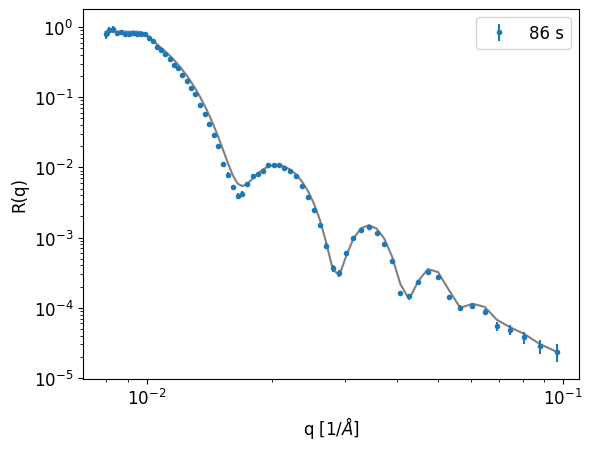

In [63]:
# choose a random action or use our initial fit
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)

# Train or load model

In [ ]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-bck-3/",
    name_prefix="rl_model-backward",
    save_replay_buffer=False,
    save_vecnormalize=True,
)


TRAIN = True

if TRAIN:
    model = SAC('MlpPolicy', env, use_sde=False, verbose=0, learning_rate=0.001)

    #model.learn(2000)
    model.learn(20000000, callback=checkpoint_callback, reset_num_timesteps=False)
    model.save('d17-SAC-backward-3')
else:
    model = SAC.load('d17-SAC-backward', env=env)

# Run the prediction on the data

In [30]:
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 80
Time 790 [1.]: -0.262986 [False] -0.262986
Time 780 [0.98734176]: -0.230981 [False] -0.493966
Time 770 [0.9746835]: -0.26311 [False] -0.757076
Time 760 [0.96202534]: -0.19792 [False] -0.954996
Time 750 [0.9493671]: -0.258948 [False] -1.21394
Time 740 [0.93670887]: -0.181198 [False] -1.39514
Time 730 [0.9240506]: -0.226365 [False] -1.62151
Time 720 [0.9113924]: -0.269602 [False] -1.89111
Time 710 [0.89873415]: -0.260436 [False] -2.15155
Time 700 [0.886076]: -0.273056 [False] -2.4246
Time 690 [0.87341774]: -0.266275 [False] -2.69088
Time 680 [0.8607595]: -0.273886 [False] -2.96476
Time 670 [0.84810126]: -0.253877 [False] -3.21864
Time 660 [0.835443]: -0.191006 [False] -3.40965
Time 650 [0.8227848]: -0.258068 [False] -3.66771
Time 640 [0.8101266]: -0.261667 [False] -3.92938
Time 630 [0.79746836]: -0.167905 [False] -4.09729
Time 620 [0.7848101]: -0.253634 [False] -4.35092
Time 610 [0.7721519]: -0.199507 [False] -4.55043
Time 600 [0.75949365]: -0.308513 [False] -4.85894


# Evaluate uncertainties

There must be a better way to do this...

In [31]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(9, 80, 100)
(9, 80)


# Plot the parameters as a function of time

['enrich thickness', 'enrich interface', 'enrich rho', 'poly thickness', 'poly interface', 'poly rho', 'surface thickness', 'surface interface', 'surface rho']


Text(0.5, 0, 'time [seconds]')

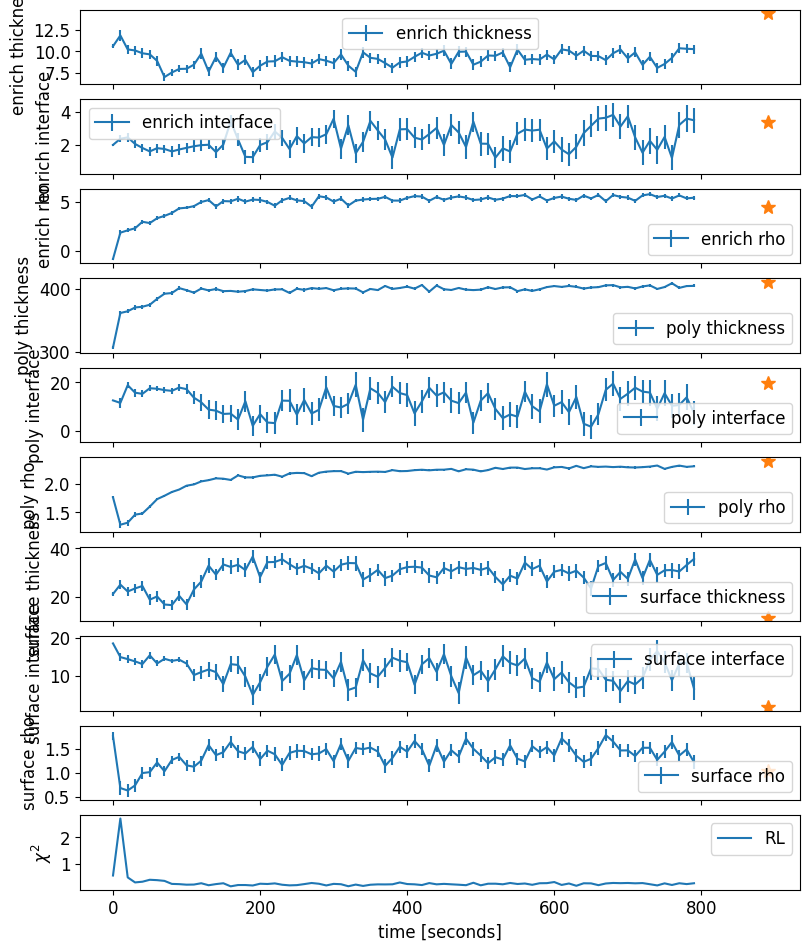

In [32]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
#with open(os.path.join(git_dir, 'data', '189245-bayes-forward.json')) as fd:
#    bayes_fits = json.load(fd)
bayes_fits = {}

t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_pars = pars.shape[0]+1

fig, axs = plt.subplots(n_pars, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(n_pars, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit')
    
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_pars, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
#plt.plot(_times, bayes_fits['chi2'], label = 'Bayesian fit')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

# Plot the fits

Number of times: 80


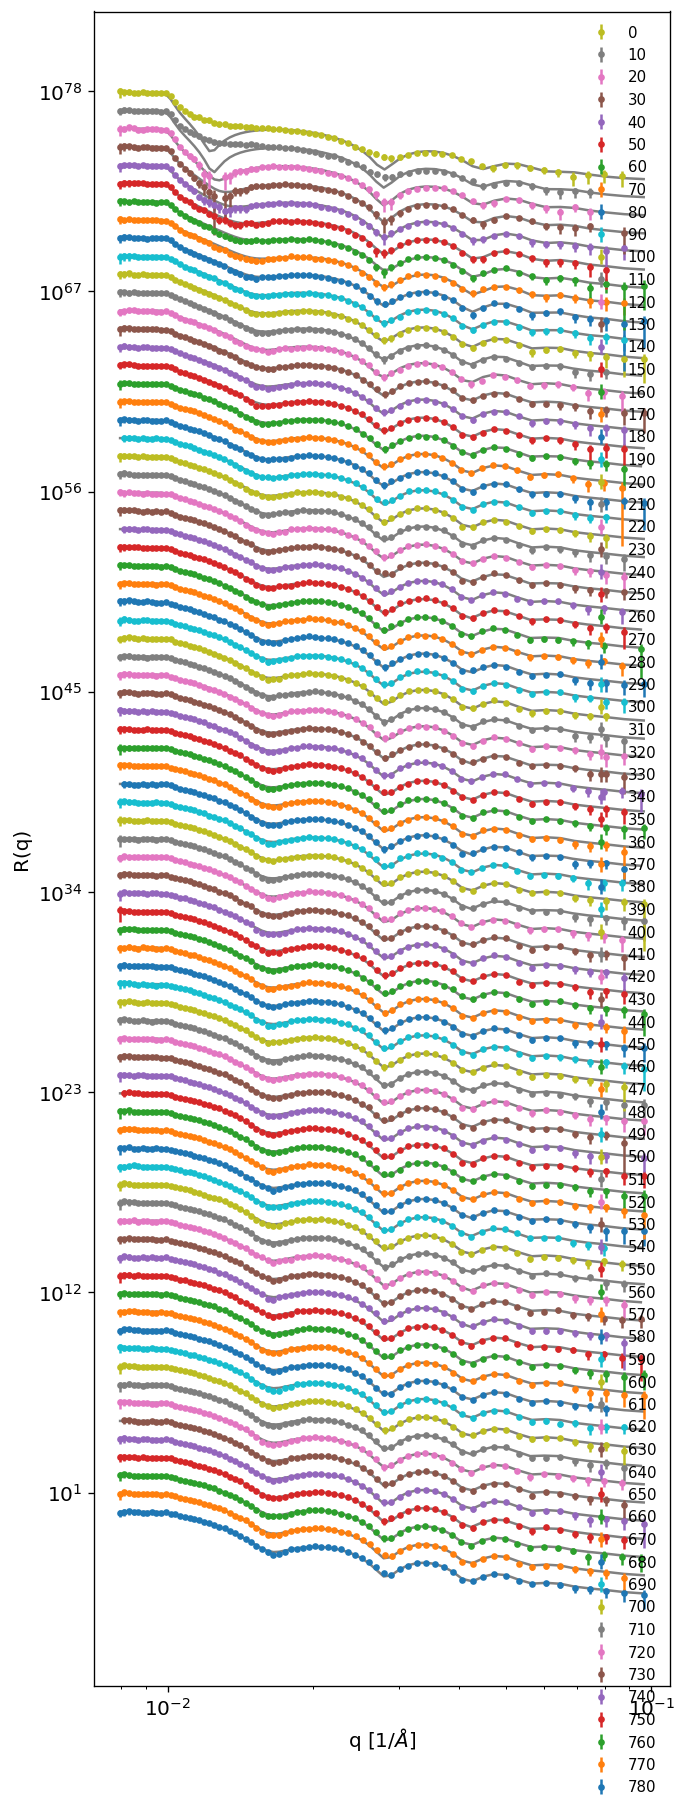

In [33]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

offset = 0
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = env.step(action)

    if True: #i%1000 == 0:
        env.plot(scale=10**offset, newfig=False, errors=True, label=_times[i])
        offset += 1

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
#plt.xlim([0.015, 0.12])
plt.show()